[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Erinin_et_al_2025/expansion_experiment.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Erinin_et_al_2025/expansion_experiment.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Erinin_et_al_2025/expansion_experiment.ipynb)

modeling expansion-chamber experiments described in [Erinin et al. 2025](https://doi.org/10.48550/arXiv.2501.01467)

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot
from PySDM import Formulae
from PySDM.physics import si, in_unit
from PySDM import products as PySDM_products
from PySDM_examples.Erinin_et_al_2025.aerosol import AerosolChamber
from PySDM_examples.Erinin_et_al_2025.expansion_simulation import run_expansion

In [3]:
dry_radius_bin_edges = np.geomspace(50 * si.nm, 2000 * si.nm, 40, endpoint=False)
wet_radius_bin_edges = np.geomspace(1 * si.um, 40 * si.um, 40, endpoint=False)

products = (
    PySDM_products.SuperDropletCountPerGridbox(name="SD count"),
    PySDM_products.WaterMixingRatio(unit="g/kg", name=r"$q_\ell$"),
    PySDM_products.PeakSupersaturation(name="Saturation ratio"),
    PySDM_products.AmbientRelativeHumidity(name="RH"),
    PySDM_products.AmbientTemperature(name="Temperature", var="T"),
    PySDM_products.AmbientPressure(name="Pressure", var="p", unit="hPa"),
    PySDM_products.AmbientWaterVapourMixingRatio(
        unit="g/kg", name="$q_v$", var="water_vapour_mixing_ratio"
    ),
    PySDM_products.Time(name="t"),
    PySDM_products.ParticleSizeSpectrumPerVolume(
        name="dry:dN/dR",
        unit="m^-3 m^-1",
        radius_bins_edges=dry_radius_bin_edges,
        dry=True,
    ),
    PySDM_products.ParticleSizeSpectrumPerVolume(
        name="wet:dN/dR",
        unit="m^-3 m^-1",
        radius_bins_edges=wet_radius_bin_edges,
        dry=False,
    ),
    PySDM_products.ActivatedEffectiveRadius(
        name="act_reff", unit="um", count_activated=True, count_unactivated=False
    ),
    PySDM_products.EffectiveRadius(
        name="$r_{eff}$",
        unit="um",
    ),
    PySDM_products.ParticleConcentration(
        name="$N_d$",
        unit="cm^-3",
        # radius_range=(0.5 * si.um, 25 * si.um),
    ),
) 

In [4]:
FORMULAE = Formulae(
    adiabatic_exponent="MoistLeadingTerms",
    homogeneous_liquid_nucleation_rate='CNT',
)
CONST = FORMULAE.constants

N_SD_PER_MODE = 20
DT = .05 * si.s

C0_arr = np.array([1e2, 2.5e2, 5e2, 7.5e2, 1e3]) / si.cm**3
C0_arr = np.array([4e2, 4.25e2, 4.5e2, 5e2, 5.5e2, 6e2]) / si.cm**3

In [6]:
output_all = {}

for Na in C0_arr:
    key = f"C0={Na:.2e}"
    print(key)
    aerosol = AerosolChamber(
        water_molar_volume=CONST.Mv / CONST.rho_w,
        N=Na,
    )
    output = run_expansion(
        formulae=FORMULAE,
        aerosol=aerosol,
        n_sd_per_mode=N_SD_PER_MODE,
        n_sd_homo_liq_nucleation=100,
        total_time=4*si.s,
        dt=DT,
        products=products,
    )

    output_all[key] = output


C0=4.00e+08
C0=4.25e+08
C0=4.50e+08
C0=5.00e+08
C0=5.50e+08
C0=6.00e+08


4.021660843931165
0.33964378383596744
0.0197293310945584
7.870157403148062e-05
4.28580000171432e-07
0.0


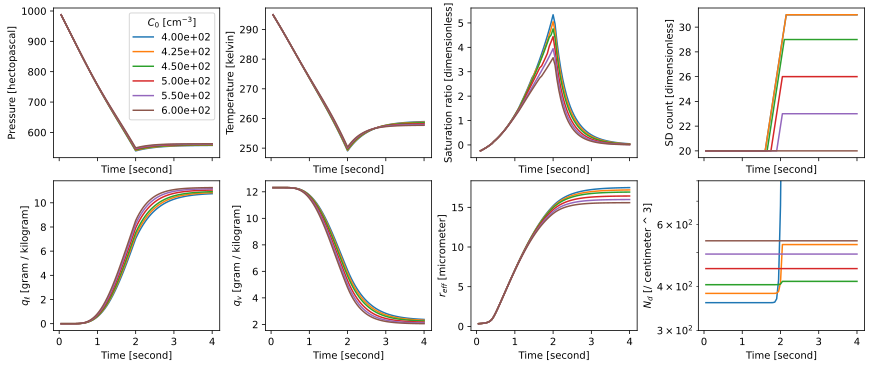

In [7]:
variables = ["Pressure", "Temperature", "Saturation ratio", "SD count", r"$q_\ell$", "$q_v$", "$r_{eff}$", "$N_d$"]
fig, axes = pyplot.subplots(2,4,figsize=(12,5), sharex=True, sharey=False, constrained_layout=True)

for Na in C0_arr:
    key = f"C0={Na:.2e}"
    output = output_all[key]
    init_mult = output.attributes["multiplicity"][0]
    final_mult = output.attributes["multiplicity"][-1]
    print((np.sum(final_mult) - np.sum(init_mult)) / np.sum(init_mult))
    for i, ax in enumerate(axes.flatten()):
        y = np.array(output.profile[variables[i]])
        ax.plot(output.profile["t"], y, label=f"{in_unit(Na, 1/si.cm**3):.2e}")
        if i == 7:
            ax.set_yscale("log")
            ax.set_ylim(3e2,8e2)
        ax.set_xlabel(f"Time [{output.units['t']}]")
        ax.set_ylabel(f"{variables[i]} [{output.units[variables[i]]}]")

axes[0, 0].legend(title="$C_0$ [cm$^{-3}$]")
show_plot("C0_sweep_traces.pdf")

In [12]:
DP = np.insert(np.linspace(100, 500, 5), 0, 1) * si.hPa
P0 = 1000 * si.hPa

cases = {
    'base': {'N': 2000 / si.cm**3, 'RH0': 0.5, 'color': 'green'},
    'clean': {'N': 1 / si.cm**3, 'RH0': 0.5, 'color': 'turquoise'},
    'dry': {'N': 1 / si.cm**3, 'RH0': 0, 'color': 'black'},
}
output = {
    'Smax': {case: [] for case in cases},
    'Tmin': {case: [] for case in cases},
}
for dpi in DP:
    for case, case_params in cases.items():
        print(f"{dpi=} {case=}")
        aerosol = AerosolChamber(water_molar_volume=CONST.Mv / CONST.rho_w, N=case_params['N'])
        out = run_expansion(
            formulae=FORMULAE,
            aerosol=aerosol,
            n_sd_per_mode=N_SD_PER_MODE,
            RH0=case_params['RH0'],
            pf=(P0 - dpi),
            dt=DT,
            p0=P0,
            products=products
        )
        output['Tmin'][case].append(np.nanmin(out.profile["Temperature"]))
        output['Smax'][case].append(np.nanmax(out.profile["Saturation ratio"]))

dpi=100.0 case='base'
dpi=100.0 case='clean'
dpi=100.0 case='dry'
dpi=10000.0 case='base'
dpi=10000.0 case='clean'
dpi=10000.0 case='dry'
dpi=20000.0 case='base'
dpi=20000.0 case='clean'
dpi=20000.0 case='dry'
dpi=30000.0 case='base'
dpi=30000.0 case='clean'
dpi=30000.0 case='dry'
dpi=40000.0 case='base'
dpi=40000.0 case='clean'
dpi=40000.0 case='dry'
dpi=50000.0 case='base'
dpi=50000.0 case='clean'
dpi=50000.0 case='dry'


In [34]:
def plot(_axes, _output, _cases, var):
    for _case, _case_params in _cases.items():
        _axes.plot(
            DP / P0,
            _output[var][_case],
            color=_case_params['color'],
            marker="o",
            ls="--",
            label=f"$S_0={_case_params['RH0']}, C_0={in_unit(_case_params['N'], si.cm**-3)}$ cm$^{{-3}}$"
        )

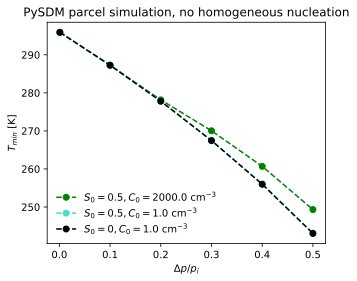

In [35]:
fig, ax = pyplot.subplots(1, 1, figsize=(5,4))
plot(ax, output, cases, var='Tmin')
ax.set_xlabel(r"$\Delta p / p_i$")
ax.set_ylabel(r"$T_{min}$ [K]")
ax.legend(loc=3, frameon=False)
ax.set_title("PySDM parcel simulation, no homogeneous nucleation")
show_plot("Tmin_dp.pdf")

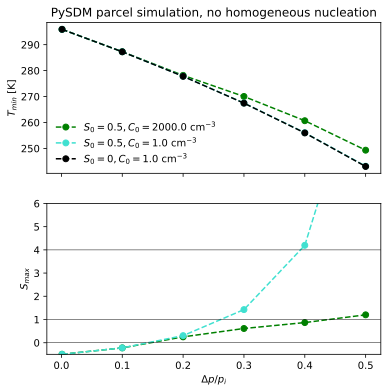

In [33]:
fig, axs = pyplot.subplots(2,1,figsize=(6,6),sharex=True)
plot(axs[0], output, cases, var='Tmin')
axs[0].set_ylabel(r"$T_{min}$ [K]")
axs[0].legend(loc=3, frameon=False)
axs[0].set_title("PySDM parcel simulation, no homogeneous nucleation")
plot(axs[1], output, cases, var='Smax')
axs[1].set_xlabel(r"$\Delta p / p_i$")
axs[1].set_ylabel(r"$S_{max}$")
axs[1].set_ylim(-0.5, 6)
for value in (0, 1, 4):
    axs[1].axhline(value, color="k", lw=0.5)
show_plot("dp_sweep.pdf")